# Promiss application 2.0

Structure of the jupyter file:
    
- General functions used to create all dataframes
- General functions used in different algorithms
- Algorithm: What is the food preference of the user (vegetarian, pescotarian)?
- general function used in multiple algorithms to check wheather meal is vega/pesco
- Algorithm: Get meal based on protein points
- Algorithm: Preset
- Algorithm: Core + addition
- Algoritme: Association rule learning
- Trouble finding a day with input for testing the protein points algorithm? Check here
- Evaluation:
    - How long is the training period?: Evaluate preset
    - Number of clicks evaluation
        - Gather days for evaluation
        - Amount of clicks new application
        - Amount of clicks old application
        - Evaluation: T-test + P-value


### General functions used to create all dataframes

In [45]:
import sqlite3
import pandas as pd
from collections import Counter

In [46]:
DATA_PATH = "/Users/dewispooren/surfdrive/Shared/PROMISS data/Data/"

In [47]:
#Only used the users where the threshold of filling in their meals >= 70%. 
#Also did not take into account users with more than 1 tablet, because those results were not reliable
users = [20197, 20251, 20334, 20373, 20477, 20486, 20491, 20503, 20614, 20629, 20683]

All_logging is used in the algorithms, because not all logging data is used in the algorithms. Evaluation_logging 
contains all logging data which we can use to evaluate the algorithms.

In [48]:
all_protein_products = {}
all_logging = {}
all_day_totals = {}
all_messages = {}
all_pref_alt = {}
all_pref_menu = {}
evaluation_logging = {}

In [49]:
def read_databases3(number, select_file, result_file):

    db_location = DATA_PATH + str(number) + ".db"
    cnx = sqlite3.connect(db_location)
    df_file = pd.read_sql_query(select_file, cnx)
    
    result_file[number] = df_file

In [50]:
for part in users:
    if part != 20245: #deze deelnemer heeft een lege database, dus die wordt overgeslagen
        read_databases3(part, 'SELECT * FROM day_totals', all_day_totals)
        read_databases3(part, 'SELECT * FROM messages', all_messages)
        read_databases3(part, 'SELECT * FROM protein_products', all_protein_products)
        read_databases3(part, 'SELECT * FROM logging', all_logging)
        read_databases3(part, 'SELECT * FROM logging', evaluation_logging)
        read_databases3(part, 'SELECT * FROM pref_alt', all_pref_alt)
        read_databases3(part, 'SELECT * FROM pref_menu', all_pref_menu)

In [51]:
#training time is 10 weeks
training_days = 70

def create_timeframes(user, week):
    df = all_logging[user]
    days_list = (df['intakeDay'].unique().tolist())
    
    if week <= len(days_list):
        x = days_list[:week]
        index_split = df[df.intakeDay == x[-1]].index.values[0]
        final_df = df[0:index_split+1]
        evaluation_df = df
    else:
        final_df = df
        evaluation_df = df
    return final_df, evaluation_df

for user in users:
    all_logging[user], evaluation_logging[user] = create_timeframes(user, training_days)

### General functions used in different algorithms

For the different steps, we often have to use the same kind of algorithm. Below there are three different algorithms. the function get_meal_ids retrieves the meal the user has filled in. It retrieves the time of the day, the amount of protein points and the id's of the product from the meal.

The function get_sorted_categories is used to change the id's to the categories the id belongs to. The same meals can be filled in in a different order, that is why we order it alphabetically. 

the function get_sorted_products is used to change the id's to the product the id belongs to. The same meals can be filled in in a different order, that is why we order them according to the id's.

In [54]:
import numpy

def get_meal_ids(user):
    df = all_logging[user]
    df = df.loc[(df['action'] == 'response') & (df['type'] == 'advice')]
    value_list = df['value'].tolist()

    meal_list_structured = []

    for i in value_list:
        split1 = i.split(':')

        meal_time = (split1[0].split('-')[0])
        protein_points = (split1[0].split('-')[1])
        meal_list_structured.append([meal_time, protein_points])

        split2 = (split1[1].split(','))
        product_ids = []
        for id in split2:
            if id != '':
                product_ids.append(int(id.split('-')[0]))
        meal_list_structured.append(product_ids)
    return meal_list_structured

def get_sorted_categories(user):
    final_sorted_categories = []
    df_products = all_protein_products[user]
    sorted_categories = get_meal_ids(user)
    for x in range(len(sorted_categories)):
        if (x % 2) == 0:
            if sorted_categories[x+1] != []:
                final_sorted_categories.append(sorted_categories[x])
        else:
            ids = sorted_categories[x]
            if (ids) != []:
                categories = []
                for l in range(len(ids)):
                    categories.append(df_products.loc[df_products['ID'] == (ids[l])]['type'].item())
                categories.sort()
                final_sorted_categories.append(categories)
    return final_sorted_categories

def get_specific_sorted_categories(user, time):
    meal_list_types = get_sorted_categories(user)
    all_specific_meals_types = []
    for i in range(len(meal_list_types)):
        if meal_list_types[i][0] == time:
            all_specific_meals_types.append([meal_list_types[i+1], meal_list_types[i][1]])
    return all_specific_meals_types

def get_sorted_products(user):
    final_sorted_products = []
    df_products = all_protein_products[user]
    sorted_products = get_meal_ids(user)
    for x in range(len(sorted_products)):
        if (x % 2) == 0:
            if sorted_products[x+1] != []:
                final_sorted_products.append(sorted_products[x])
        else:
            ids = sorted_products[x]
            if (ids) != []:
                ids.sort()
                products = []
                for l in range(len(ids)):
                    products.append(df_products.loc[df_products['ID'] == (ids[l])]['name'].item())
                final_sorted_products.append(products)
    return final_sorted_products

def get_specific_sorted_products(user, time):
    meal_list_names = get_sorted_products(user)
    all_specific_meals_names = []
    for i in range(len(meal_list_names)):
        if meal_list_names[i][0] == time:
            all_specific_meals_names.append([meal_list_names[i+1], meal_list_names[i][1]])
    return all_specific_meals_names

def get_prob_number(user_list):
    prob_list = []
    total = 0
    for i in range(len(user_list)):
        total += user_list[i][1]
    if total != 0:
        for i in range(len(user_list)):
            prob_list.append(user_list[i][1] / total)
        length = len(user_list)
        prob_number = numpy.random.choice(numpy.arange(0, length), p=prob_list)
    else:
        length = len(user_list)
        prob_number = np.random.randint(0, length)
    return prob_number

def create_dict_counter(lis):
    dict_lis = Counter(tuple(x) for x in lis)
    main_dict = dict_lis.most_common(10)
    return main_dict


### Algorithm: What is the food preference of the user (vegetarian, pescotarian)?

As can be seen in the flowchart, there are two different ways of knowing the food preference of the user. If the user is new and thus has no previous data, it is asked when using the application for the first time. When the user is one of the active (threshold >= 70) participants of the Promiss research the algorithms below check whether the diet of the user represents a vegetarian/pescotarian diet. 

In [55]:
def add_veg_column(all_users, all_protein_products):
    for user in all_users:
        vega_list = ['vega'] * len(all_protein_products[user]['ID'])
        
        vlees_list = [115, 185, 163, 196, 208, 213, 243, 245, 246, 247, 249, 250, 255, 257, 262, 263, 265, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 278, 279, 282, 283, 284, 286, 287,290, 291, 292, 293, 294, 296, 297, 302, 303, 304, 306, 310, 312, 313, 314, 317]
        vis_list = [177, 33, 78, 182, 214, 224, 241, 242, 253, 254, 260, 261, 266, 277, 280, 281, 285, 288, 289, 295, 298, 300, 301, 305, 307, 308, 309, 311, 315, 344]

        for i in range(len(vega_list)):
            if i in vlees_list:
                vega_list[i] = 'vlees'
            if i in vis_list:
                vega_list[i] = 'vis'

        all_protein_products[user]['Vegetarian'] = vega_list
    return all_protein_products

In [56]:
all_protein_products = add_veg_column(users, all_protein_products)

In [57]:
def is_meal_veg(user):
    sorted_products = get_sorted_products(user)
    meal_veg = []
    for meal in sorted_products[1::2]:
        product_veg = []
        for product in meal:
            df = all_protein_products[user] 
            x = df.loc[df['name'] == product]['Vegetarian'].item()
            product_veg.append(x)
        if 'vlees' in product_veg:
            meal_veg.append([meal, 'not vegetarian'])
        if 'vis' in product_veg and 'vlees' not in product_veg:
            meal_veg.append([meal, 'pescotarian'])
        else: 
            meal_veg.append([meal, 'vegetarian'])
    return meal_veg

def percentages_food_pref(user):
    meal_veg = is_meal_veg(user)
    vegetarian = 0
    pescotarian = 0
    meals = 0
    for meal in meal_veg:
        meals +=1
        if (meal[1]) == 'vegetarian':
            vegetarian += 1
        if (meal[1]) == 'pescotarian' or (meal[1]) == 'vegetarian':
            pescotarian += 1
    percentage_vegetarian = round((vegetarian / meals) * 100, 2)
    percentage_pescotarian = round((pescotarian / meals) * 100, 2)
    return percentage_vegetarian, percentage_pescotarian

def resulting_food_pref(user):
    veg, pes = percentages_food_pref(user)
    food_pref = 'all'
    if veg >= 99:
        food_pref = 'vega'
    elif pes >= 99:
        food_pref = 'pesco'
    return food_pref

### General functions used in multiple algorithms to check wheather meal is vega/pesco

In [58]:
def check_meal_vega(meal, user):
    pref_meal = 'yes'
    df = all_protein_products[user]
    for product in meal:
        x = df.loc[df['name'] == product]['Vegetarian'].item()
        if x == 'vlees':
            pref_meal = 'no'
    return pref_meal

def check_meal_pesco(meal, user):
    pref_meal = 'yes'
    df = all_protein_products[user]
    for product in meal:
        x = df.loc[df['name'] == product]['Vegetarian'].item()
        if x == 'vlees' or x == 'vis':
            pref_meal = 'no'
    return pref_meal

### Algorithm: Get meal based on protein points

Below the functions for the protein points algorithm can be seen. This algorithm is only used when a user fills in a meal for 'Avondeten' or 'Tussendoor avond. The meals for the specific eating moment will be divided into clusters using K-means clustering. 
Using a plot, the highest silhouette coefficient is determined and therefore the appropriate number of clusters. Subsequently, based on the amount of protein left, it is decided which cluster is closest to this amount. From this cluster a meal is chosen. 

In [59]:
def get_unique_meals_point(users, time):
    all_specific_meals_names = []
    for user in users:
        meal_list_names = get_sorted_products(user)
        for i in range(len(meal_list_names)):
            if meal_list_names[i][0] == time:
                all_specific_meals_names.append([meal_list_names[i+1], meal_list_names[i][1]])
    unique_points = []
    for number in all_specific_meals_names:
        if number in unique_points:
            continue
        else:
            unique_points.append(number)
    unique_count = []
    for u in unique_points:
        counter = 0
        for meal in all_specific_meals_names:
            if meal == u:
                counter +=1
        unique_count.append([u[0], counter])
    return unique_points, unique_count


In [60]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

def get_number_of_clusters(users, time):
    unique_meals_point, unique_count = get_unique_meals_point(users, time)
    
    X = []
    meal_with_points = []
    for meal in unique_meals_point:
        if float(meal[1]) != 0:
            x = float(meal[1]) - 0.5
            y = float(meal[1]) + 0.5
            X.append([x,y])
            meal_with_points.append([meal[0], meal[1]])

    silhouette_coefficients = []
    for k in range(2, 40):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_coefficients.append(score)

    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(30,10))
    x = range(2,40)
    plt.plot(x, silhouette_coefficients)
    plt.xticks(range(2, 40))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()

    ymax = max(silhouette_coefficients)
    xpos = silhouette_coefficients.index(ymax)
    print('best silhouette score for ', time, ' is: ', silhouette_coefficients[xpos], 'with number of clusters: ', x[xpos], '\n')
    xmax = x[xpos]
    return xmax, meal_with_points, X, unique_count

In [61]:
def create_classes(users, time):
    xmax, meal_with_points, X, unique_count = get_number_of_clusters(users, time)
    features, true_labels = make_blobs(n_samples=xmax, centers=xmax, cluster_std=2.75, random_state=42)
    X = X
    y = true_labels

    kmeans = KMeans(n_clusters=xmax, random_state=42)

    kmeans.fit(X)
    #comment the next three lines if you want to show the different clusters
    #print('These are the classes:')
    #for i in range(len(kmeans.cluster_centers_)):
     #   print(i, kmeans.cluster_centers_[i])
        
    #loop through indexes of kmeans.cluster_centers_, because every index is a class
    #Loop through the kmeans.labels_ where the index represents the same index in meals_with_points
    #add the meals from meals_with_points to a dictionary whenever it is the same as the class
    dic_classes = {}
    for k in range(len(kmeans.cluster_centers_)):
        per_class = []
        for i in range(len(kmeans.labels_)):
            if (kmeans.labels_[i]) == k:
                per_class.append(meal_with_points[i][0])
        dic_classes[k] = per_class
    return dic_classes, kmeans.cluster_centers_, unique_count

In [62]:
def closest(cluster_centers, protein):
    cluster_list1 = [item[0] for item in cluster_centers]
    cluster_list2 = [item[1] for item in cluster_centers]
    closest_index = []
    differences = []
    for i in range(len(cluster_list1)):
        diff1 = (abs(protein - cluster_list1[i]))
        diff2 = (abs(protein - cluster_list2[i]))
        add = diff1 + diff2
        differences.append(add)
        
    minimum = min(differences)
    for i in range(len(differences)):
        if differences[i] == minimum:
            closest_index.append(i)
    return closest_index

def get_meals_from_class(cluster_center, left_protein, dic_classes, users, time, unique_count): 
    final_class = (closest(cluster_center, left_protein))
    print('The user needs ', left_protein, 'protein points', 'from class ', final_class, 'for ', time, '\n')
    final_meals = []
    for i in final_class:
        for meal in dic_classes[i]:
            final_meals.append(meal)
    
    final_meal_count = []
    for meal_count in unique_count:
        for meal2 in final_meals:
            if meal_count[0] == meal2 and meal_count not in final_meal_count:
                final_meal_count.append(meal_count)

    final_meal_count = sorted(final_meal_count, key = lambda x: x[1], reverse=True)
    return final_meal_count


In [63]:
def meals_by_preference(preference, meals):
    correct_meals = []
    if preference == 'vega':
        for meal in meals:
            #Can make use here of only user 20197 because all protein_products dataframes are the same
            x = check_meal_vega(meal[0], 20197)
            if x == 'yes':
                correct_meals.extend(meal)
    elif preference == 'pesco':
        for meal in meals:
            x = check_meal_pesco(meal[0], 20197)
            if x == 'yes':
                correct_meals.extend(meal)
    elif preference == 'all':
        correct_meals = meals
    return correct_meals

In [64]:
def chosen_meal_protein(user, day, time_o_day):
    df = evaluation_logging[user]
    df = df.loc[((df['content'] == 'confirmation') & (df['type'] == 'advice')) | (df['type'] == 'advice') & (df['content'] == 'confirmation-changed') | (df['action'] == 'shown') & (df['type'] == 'advice')]

    times_list = []
    meal_list = []
    for index, row in df.iterrows():
        if(row.intakeDay) == None:
            times_list.append('None')
            meal_list.append(row.value)
        else:
            val = row.value.split(':')[0]    
            v = val.split('-')[0]
            times_list.append(v)
            meal = row.value.split(':')[0]
            meal2 = meal.split('-')[1]
            meal_list.append(meal2)
    df['times'] = times_list
    df['value'] = meal_list

    confirmations = df.loc[(df['content'] == 'confirmation') & (df['intakeDay'] == day) & (df['times'] == time_o_day)]
    id_chosen = confirmations['id'].tolist()
    if id_chosen != []:
        chosen_meal = df.loc[df['id'] == id_chosen[-1]].value.item()
    
    return chosen_meal

If the protein left is more than 0.3 * protein need, we need to distribute the protein left between 'Avondeten' and 'Tussendoor avond'. So protein_left is 0.75 * protein_left.

In [65]:
def protein_algorithm(users, user, time_protein_left, today, preference):
    df = pd.read_excel('/Users/dewispooren/surfdrive/Shared/PROMISS data/thresholds deelnemers2.xlsx')
    df = df.rename(columns={'Unnamed: 0': 'User'})
    protein_need = df.loc[df['User'] == user]['Total'].item()
    
    total_protein = all_day_totals[user].loc[all_day_totals[user]['day'] == today]['total'].item()
    
    minus_protein = chosen_meal_protein(user, today, time_protein_left[0]) #This line is used for evaluation
    time_protein_left.append(protein_need - (total_protein-float(minus_protein))) #This line is used for evaluation
                             
    #time_protein_left.append((protein_need - (total_protein))  #uncomment this line if it is not used for evaluation
    
    if time_protein_left[0] == time_protein_left[0]:
        if time_protein_left[1] > 0.3 * protein_need:
            time_protein_left[1] == 0.75 * time_protein_left[1]
    if time_protein_left[1] > 0:
        dic_class, cluster_center, unique_count = create_classes(users, time_protein_left[0])
        meals = get_meals_from_class(cluster_center, time_protein_left[1], dic_class, users, time_protein_left[0], unique_count)
        correct_meals = meals_by_preference(preference, meals)
        if correct_meals != []:
            index_number = get_prob_number(correct_meals)
            final_protein_meal = correct_meals[index_number][0]
        else:
            print('Found no meals with your preference for the amount of protein left')
            final_protein_meal = []
    else:
        print('You have eaten enough today to reach your protein points')
        final_protein_meal = []
    return final_protein_meal


### Algorithm: Preset

The preset algorithm is used when the protein points algorithm is not used. 
The algorithm transforms each meal from all users for a specific eating moment into a list of the 
categories of the products. The 10 most used presets are selected.
For the chosen preset, each category the most used product is looked at and one meal is created.

In [66]:
from collections import Counter

def create_preset(active_meal_composers, time):
    list_of_all_presets = []
    for composer in active_meal_composers:
        meals_types = get_specific_sorted_categories(composer, time)
        for meal in meals_types:
            if meal != ['']:
                list_of_all_presets.append(meal[0])
    return list_of_all_presets

def create_dict_counter(lis):
    dict_lis = Counter(tuple(x) for x in lis)
    main_dict = dict_lis.most_common(10)
    return main_dict

def get_user_preset(user, time, presets):
    meals_types = get_specific_sorted_categories(user, time)
    
    user_presets = []
    for preset in presets:
        counter = 0
        for meal in meals_types:
            if meal[0] == list(preset[0]):
                counter += 1
        user_presets.append([preset[0], counter])
    user_presets.sort(key = lambda x: x[1], reverse=True)
    return user_presets

def get_specific_meals2(meal_list_types, meal_list_names, time):
    all_specific_meals_types = []
    for i in range(len(meal_list_types)):
        if meal_list_types[i][0] in time:
            all_specific_meals_types.append((meal_list_types[i+1]))
            
    all_specific_meals_names = []
    for i in range(len(meal_list_names)):
        if meal_list_names[i][0] in time:
            all_specific_meals_names.append((meal_list_names[i+1]))
            
    return all_specific_meals_types, all_specific_meals_names


def products_by_preference(preference, products):
    correct_products = []
    if preference == 'vega':
        for product in products:
            #Can make use here of only user 20197 because all protein_products dataframes are the same
            x = check_meal_vega([product], 20197)
            if x == 'yes':
                correct_products.append(product)
    if preference == 'pesco':
        for product in products:
            x = check_meal_pesco([product], 20197)
            if x == 'yes':
                correct_products.append(product)
    else:
        for product in products:
            correct_products.append(product)
    return correct_products

#check if the product has been used sometime in the time of the day
#for example when you want a breakfast meal, and the product is wine, it is not logical to recommend wine as product
def exist_time_o_day(products, users, time_o_day):
    correct_products = []
    if len(users) == 1:
        meals = get_specific_sorted_products(users[0], time_o_day)
        for product in products:
            for meal in meals:
                if product in meal[0]:
                    correct_products.append(product)
    else:
        all_meals = []
        for ID in users:
            meals = get_specific_sorted_products(users[0], time_o_day)
            all_meals.extend(meals)
        for product in products:
            for meal in all_meals:
                if product in meal[0]:
                    correct_products.append(product)
    return correct_products

list_times = ['Avondeten', 'Ontbijt', 'Lunch', 'Tussendoor avond', 'Tussendoor middag', 'Tussendoor ochtend']

def get_most_used_products(users, category, preference, time_o_day):
    product_list = []
    for ID in users:
        df = all_protein_products[ID]
        meal_list_types = get_sorted_products(ID)
        for i in meal_list_types[1::2]:
            for j in i:
                cat = df.loc[df['name'] == j]['type'].item()
                if cat == category:
                    product_list.append(j)
    correct_products = products_by_preference(preference, product_list)
    correct_products = exist_time_o_day(correct_products, users, time_o_day)
    return Counter(correct_products).most_common()


In [67]:
def get_prob_number_preset(user_list):
    prob_list = []
    total = 0
    for i in range(len(user_list)):
        total += user_list[i][1]
    if total != 0:
        for i in range(len(user_list)):
            prob_list.append(user_list[i][1] / total)
        length = len(user_list)
        a = numpy.arange(0, len(prob_list))
        prob_number = numpy.random.choice(a, p=prob_list)
    else:
        length = len(user_list)
        prob_number = np.random.randint(0, 10)
    return prob_number

In [68]:
def preset_algorithm(users, user, time_o_day, participant, preference):
    presets = create_dict_counter(create_preset(users, time_o_day))
    if participant == 'old':
        user_presets = get_user_preset(user[0], time_o_day, presets)
        index_number = get_prob_number(user_presets)
        picked_preset = user_presets[index_number]
        #Here change users to user, because below you are going to get the most_used products for 'users'
        #And for old participants, the most_used products are only for the user
        users = user
    if participant == 'new':
        index_number = get_prob_number(presets)
        picked_preset = presets[index_number]
        
    recommended_meal = []
    for product in picked_preset[0]:
        most_used_product = get_most_used_products(users, product, preference, time_o_day)
        index_number = get_prob_number(most_used_product)
        product = most_used_product[index_number][0]
        if product in recommended_meal:
            most_used_product.remove(most_used_product[index_number])
            index_number = get_prob_number_preset(most_used_product)
            product = most_used_product[index_number][0]
        recommended_meal.append(product)
    return recommended_meal


### Algorithm: Core + addition

The core + addition algorithm is used besides the preset/protein algorithm in order to recommend the second meal. In this context, the core is a composition of two products often occurring together in a meal. The additions are products that often occur together with the core in a meal.

In [69]:
import itertools
from collections import Counter
import numpy as np

def get_combinations(list_unique, preference):
    combinations = []
    for subset in itertools.combinations(list_unique, 2):
        if preference == 'vega':
            for product in list(subset):
                x = check_meal_vega(list(subset), user)
                if x == 'yes':
                    combinations.append(list(subset))
        elif preference == 'pesco':
            for product in list(subset):
                x = check_meal_pesco(list(subset), user)
                if x == 'yes':
                    combinations.append(list(subset))
        else:
            combinations.append(list(subset))
    return combinations

def get_cores(lists, combinations):
    count = []
    for combo in combinations:
        number = 0
        for one_list in lists:
            result =  all(elem in one_list  for elem in combo)
            if result:
                number +=1
        if number != 0:
            count.append([combo, number])
    count_sorted = sorted(count, key=lambda x: x[1])
    return count_sorted[-20:]

def get_additions(lists, core, preference):
    addition_list = []
    for k in lists:
        result =  all(elem in k  for elem in core[0])
        if result:
            for j in k:
                if j not in core[0] and j not in addition_list:
                    if preference == 'vega':
                        x = check_meal_vega([j], user)
                        if x == 'yes':
                            addition_list.append(j)
                    elif preference == 'pesco':
                        x = check_meal_pesco([j], user)
                        if x == 'yes':
                            addition_list.append(j)
                    else:
                        addition_list.append(j)
    final_additions = []
    final_additions.append([core[0], addition_list])
    return final_additions

def count_additions(lists, core_additions):
    result_list = []
    for core_addition in core_additions:
        including = []
        for k in lists:
            result =  all(elem in k  for elem in core_addition[0])
            if result:
                including.append(k)
        inbetween_result = []
        for addition in core_addition[1]:
            number = 0
            for j in including:
                if addition in j:
                    number += 1
            inbetween_result.append([addition, number])
        sorted(inbetween_result, key=lambda x: x[1])
        result_list.append([core_addition[0], inbetween_result])
    return result_list


In [70]:
def get_cores_result(user, time, preference):
    spec_meals_names = get_specific_sorted_products(user, time)
    final_list = []
    for meal in (spec_meals_names):
        final_list.append(meal[0])
    unique_items = np.array(list({x for l in final_list for x in l}))
    combinations = get_combinations(unique_items, preference)
    cores = get_cores(final_list, combinations)
    return cores, final_list

In [71]:
 def core_addition_algorithm(user, time, preference):
    cores_result, spec_meals_names = get_cores_result(user, time, preference)
    index_number = get_prob_number(cores_result)
    final_core = (cores_result[index_number])
    final_additions = get_additions(spec_meals_names, final_core, preference) 
    result_list = count_additions(spec_meals_names, final_additions)

    recommended_meal = final_core[0]
    while (len(recommended_meal) !=5):
        index_number = get_prob_number(result_list[0][1])
        final_addition = result_list[0][1][index_number]
        if final_addition[0] not in recommended_meal:
            recommended_meal.append(final_addition[0])
    return recommended_meal

### Algoritme: Association rule learning

When filling in products for a meal, association rule learning is used to look at the relationships between products from the protein products list and the products in the current meal. These relationships are used to predict the next product picked.

In [72]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

def get_encoded_df(user, time):
    spec_meals_names = get_specific_sorted_products(user, time)
    spec_meals_names = [item[0] for item in spec_meals_names]
    df = pd.DataFrame(spec_meals_names)
    items = np.array(list({x for l in spec_meals_names for x in l}))
    itemset = set(items)
    encoded_vals = []
    for index, row in df.iterrows():
        rowset = set(row) 
        labels = {}
        uncommons = list(itemset - rowset)
        commons = list(itemset.intersection(rowset))
        for uc in uncommons:
            labels[uc] = 0
        for com in commons:
            labels[com] = 1
        encoded_vals.append(labels)
    encoded_vals[0]
    encoded_df = pd.DataFrame(encoded_vals)
    return encoded_df

In [73]:
def ass_rule_learning_algorithm(user, time_o_day, added_products):
    encoded_df = get_encoded_df(user, time_o_day)
    freq_items = apriori(encoded_df, min_support=0.05, use_colnames=True, verbose=1)
    rules = association_rules(freq_items, metric="confidence", min_threshold=0.2)
    consequent_support = []
    for index, row in rules.iterrows():
        if added_products in list(row['antecedents']):
            consequent_support.append([list(row['consequents']), row['support']])
    
    if consequent_support != []:
        final_consequent = []
        while (len(final_consequent) !=2):
            index_number = get_prob_number(consequent_support)
            products = consequent_support[index_number][0]
            for product in products:
                if product not in final_consequent:
                    if len(final_consequent) != 2:
                        final_consequent.append(product)
    else:
        final_consequent = []
        print('no consequents')
    return final_consequent

If the user is an old user, then the first meal is composed using the protein algorithm or the preset algorithm. When the user wants to fill in a meal for 'Avondeten', or 'Tussendoor avond', then the amount of protein left is taken into consideration and the protein algorithm is used. Otherwise the preset algorithm is used. 

When the user is a new user, then the first meal is composed using the same as the old user, however there are a few adjustments made in both the protein and preset algorithm so we can use it for both new and old users. 

For the protein algorithm, the users variable is used to create the individual clusters. when a user is new, it has no old data to create the clusters, so we look at all active users. If it is an old user, the variable users = [user], if it is a new user, the variable users = [users], meaning all the active users. 

When using the preset algorithm, the users variable is used to get the most used products for an user. But this cannot be done for a new user, therefore we use all the active users. So, for an old user, users = user, but for a new user, users = users.

### Trouble finding a day with input for testing the protein points algorithm? Check here:


When you want to test the algorithm for the protein points, use the function below.

Because a lot of users have filled in their entire day and thus are no longer missing protein points it can be 
difficult to find a day to test the protein algorithm. Below you can see all the days the user has not
finished all protein points. Besides this, you can also change the total_protein in the protein_algorithm function 
to an arbitrary number. 

In [70]:
def not_finished_days(user, evaluation_logging):
    df = pd.read_excel('/Users/dewispooren/surfdrive/Shared/PROMISS data/thresholds deelnemers2.xlsx')
    df = df.rename(columns={'Unnamed: 0': 'User'})
    protein_need = df.loc[df['User'] == user]['Total'].item()
    
    days = evaluation_logging[user]['intakeDay'].unique().tolist()
    days.remove(None)

    snack_days = []
    for day in days:
        day_times = []
        times = evaluation_logging[user].loc[evaluation_logging[user]['intakeDay'] == day]['value'].tolist()
        for time in times:
            day_times.append(time.split('-')[0])
        if 'Avondeten' not in day_times and 'Tussendoor avond' not in day_times:
            total_protein = all_day_totals[user].loc[all_day_totals[user]['day'] == day]['total'].item()
            snack_days.append([day, (protein_need - total_protein), 'Avondeten', 'Tussendoor avond'])
        elif 'Tussendoor avond' not in day_times:
            total_protein = all_day_totals[user].loc[all_day_totals[user]['day'] == day]['total'].item()
            snack_days.append([day, (protein_need - total_protein), 'Tussendoor avond'])
        elif 'Avondeten' not in day_times:
            total_protein = all_day_totals[user].loc[all_day_totals[user]['day'] == day]['total'].item()
            snack_days.append([day, (protein_need - total_protein), 'Avondeten'])
    return snack_days

user = 20197
not_finished_days(user, evaluation_logging)

[['4/14/2019', 0.5, 'Tussendoor avond'],
 ['4/17/2019', 3.5, 'Tussendoor avond'],
 ['4/22/2019', 4.5, 'Tussendoor avond'],
 ['4/29/2019', -2.5, 'Tussendoor avond'],
 ['5/10/2019', 1.0, 'Tussendoor avond'],
 ['5/19/2019', 1.5, 'Tussendoor avond'],
 ['6/8/2019', 1.0, 'Tussendoor avond'],
 ['6/14/2019', -2.5, 'Tussendoor avond'],
 ['6/15/2019', -1.0, 'Tussendoor avond'],
 ['6/16/2019', -3.0, 'Tussendoor avond'],
 ['7/4/2019', -1.0, 'Tussendoor avond'],
 ['7/6/2019', 5.5, 'Tussendoor avond'],
 ['7/8/2019', -3.0, 'Tussendoor avond']]

In [172]:
#97, 240
users = [20197, 20251, 20334, 20373, 20477, 20486, 20491, 20503, 20614, 20629, 20683]
days = evaluation_logging[20683]['intakeDay'].unique().tolist()
print(len(days))

43


# Evaluatie

# How long is the training period?: Evaluate preset


To know how many training data we have to use, we check for multiple weeks the preset. 
We compare these presets with the preset using all data. Using this information,
we decide based on similarity and on amount of weeks how long the training period is.
For example if we have a similarity of 90% after 20 weeks and a similarity of 80% after 5 weeks,
then it can be concluded to use 5 weeks as training period. Because it is also important how long 
the user has to use the application before it functions optimal.

In [ ]:
def create_timeframes(user, week):
    df = evaluation_logging[user]
    df = df.loc[(df['action'] == 'response') & (df['type'] == 'advice')]
    days_list = (df['intakeDay'].unique().tolist())
    if week <= len(days_list):
        restricted_days = days_list[:int(week)]
        final_df = df[df['intakeDay'].isin(restricted_days)]
    else:
        final_df = df
    return final_df

def get_meal_ids2(user, week):
    #df = all_logging[user]
    #df = df.loc[(df['action'] == 'response') & (df['type'] == 'advice')]
    df = create_timeframes(user, week)
    value_list = df['value'].tolist()

    meal_list_structured = []

    for i in value_list:
        split1 = i.split(':')

        meal_time = (split1[0].split('-')[0])
        protein_points = (split1[0].split('-')[1])
        meal_list_structured.append([meal_time, protein_points])

        split2 = (split1[1].split(','))
        product_ids = []
        for id in split2:
            if id != '':
                product_ids.append(int(id.split('-')[0]))
        meal_list_structured.append(product_ids)
    return meal_list_structured

def get_sorted_categories2(user, week):
    final_sorted_categories = []
    df_products = all_protein_products[user]
    sorted_categories = get_meal_ids2(user, week)
    for x in range(len(sorted_categories)):
        if (x % 2) == 0:
            if sorted_categories[x+1] != []:
                final_sorted_categories.append(sorted_categories[x])
        else:
            ids = sorted_categories[x]
            if (ids) != []:
                categories = []
                for l in range(len(ids)):
                    categories.append(df_products.loc[df_products['ID'] == (ids[l])]['type'].item())
                categories.sort()
                final_sorted_categories.append(categories)
    return final_sorted_categories

def get_specific_sorted_categories2(user, time, week):
    meal_list_types = get_sorted_categories2(user, week)
    all_specific_meals_types = []
    for i in range(len(meal_list_types)):
        if meal_list_types[i][0] == time:
            all_specific_meals_types.append([meal_list_types[i+1], meal_list_types[i][1]])
    return all_specific_meals_types

def create_preset2(active_meal_composers, time, week):
    list_of_all_presets = []
    for composer in active_meal_composers:
        meals_types = get_specific_sorted_categories2(composer, time, week)
        for meal in meals_types:
            if meal != ['']:
                list_of_all_presets.append(meal[0])
    return list_of_all_presets

def create_dict_counter2(lis):
    dict_lis = Counter(tuple(x) for x in lis)
    main_dict = dict_lis.most_common(10)
    return main_dict


In [ ]:
users = [20197, 20251, 20334, 20373, 20477, 20486, 20491, 20503, 20614, 20629, 20683]

weeks = list(range(7,250,7))
presets = []
for week in weeks:
    preset = create_dict_counter2(create_preset2(users, 'Avondeten', week))
    presets.append(preset)

In [ ]:
preset_avondeten = presets[-1]

preset_without_count = []
for meal in preset_avondeten:
    preset_without_count.append(meal[0])

percentage = []
for preset in presets:
    count = 0
    for i in range(10):
        if preset[i][0] in preset_without_count:
            count += 10
    percentage.append(count)
print(percentage)

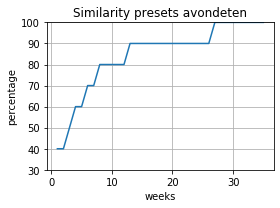

In [159]:
import matplotlib.pyplot as plt

weeks = list(range(7,250,7))
percentage = [40, 40, 50, 60, 60, 70, 70, 80, 80, 80, 80, 80, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 100, 100, 100, 100, 100, 100, 100, 100, 100]
new_weeks = list(range(1, len(weeks)+1))

fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylim([30,100])
ax.plot(new_weeks, percentage)

ax.set(xlabel='weeks', ylabel='percentage',
       title='Similarity presets avondeten')
ax.grid()

plt.tight_layout()
plt.savefig('preset_avondeten.png')

plt.show()

In [ ]:
users = [20197, 20251, 20334, 20373, 20477, 20486, 20491, 20503, 20614, 20629, 20683]

weeks = list(range(7,250,7))
presets = []
for week in weeks:
    preset = create_dict_counter2(create_preset2(users, 'Lunch', week))
    presets.append(preset)

In [ ]:
preset_avondeten = presets[-1]

preset_without_count = []
for meal in preset_avondeten:
    preset_without_count.append(meal[0])

percentage = []
for preset in presets:
    count = 0
    for i in range(10):
        if preset[i][0] in preset_without_count:
            count += 10
    percentage.append(count)
print(percentage)

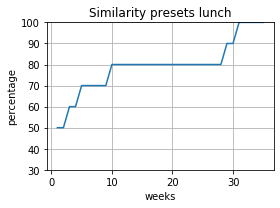

In [158]:
import matplotlib.pyplot as plt

percentage = [50, 50, 60, 60, 70, 70, 70, 70, 70, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 90, 90, 100, 100, 100, 100, 100]
new_weeks = list(range(1, len(weeks)+1))

fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylim([30,100])
ax.plot(new_weeks, percentage)

ax.set(xlabel='weeks', ylabel='percentage',
       title='Similarity presets lunch')
ax.grid()

plt.tight_layout()
plt.savefig('preset_lunch.png')

plt.show()

In [ ]:
users = [20197, 20251, 20334, 20373, 20477, 20486, 20491, 20503, 20614, 20629, 20683]

weeks = list(range(7,250,7))
presets = []
for week in weeks:
    preset = create_dict_counter2(create_preset2(users, 'Ontbijt', week))
    presets.append(preset)

In [ ]:
preset_avondeten = presets[-1]

preset_without_count = []
for meal in preset_avondeten:
    preset_without_count.append(meal[0])

percentage = []
for preset in presets:
    count = 0
    for i in range(10):
        if preset[i][0] in preset_without_count:
            count += 10
    percentage.append(count)
print(percentage)

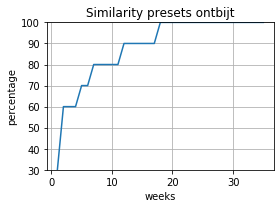

In [157]:
import matplotlib.pyplot as plt

percentage = [30, 60, 60, 60, 70, 70, 80, 80, 80, 80, 80, 90, 90, 90, 90, 90, 90, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
new_weeks = list(range(1, len(weeks)+1))

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(new_weeks, percentage)
ax.set_ylim([30,100])

ax.set(xlabel='weeks', ylabel='percentage',
       title='Similarity presets ontbijt')
ax.grid()

plt.tight_layout()
plt.savefig('preset_ontbijt.png')

plt.show()

# Number of clicks evaluation


## Gather days for evaluation

Not every user has data for each day in order to calculate the number of clicks. Therefore for each user the days with input are searched for below. These days will be used to evaluate. 

In [74]:
def create_timeframes2(user, week):
    df = evaluation_logging[user]
    days_list = (df['intakeDay'].unique().tolist())
    
    x = days_list[week:]
    index_split = df[df.intakeDay == x[0]].index.values[0]
    final_df = df[index_split+1:]
    return final_df

I only used data from: 20334, 20373, 20477, 20486, 20491, 20503, 20629
The other users did not have 70 days of data.

In [77]:
user = 20334

df = create_timeframes2(user, 70)
df = df.loc[((df['content'] == 'confirmation') & (df['type'] == 'advice')) | (df['type'] == 'advice') & (df['content'] == 'confirmation-changed') | (df['action'] == 'shown') & (df['type'] == 'advice')]

times_list = []
for index, row in df.iterrows():
    if(row.intakeDay) == None:
        times_list.append('None')
    else:
        val = row.value.split(':')[0]    
        v = val.split('-')[0]
        times_list.append(v)
df['times'] = times_list
df = df.loc[(df['content'] == 'confirmation')]

times = df['times'].tolist()
intakedays = df['intakeDay'].tolist()

ontbijt = []
tussendoor_ochtend = []
lunch = []
tussendoor_middag = []
avondeten = []
tussendoor_avond = []

for i in range(len(times)):
    if times[i] == 'Ontbijt':
        ontbijt.append(intakedays[i])
    if times[i] == 'Avondeten':
        avondeten.append(intakedays[i])
    if times[i] == 'Lunch':
        lunch.append(intakedays[i])
    if times[i] == 'Tussendoor ochtend':
        tussendoor_ochtend.append(intakedays[i])
    if times[i] == 'Tussendoor middag':
        tussendoor_middag.append(intakedays[i])
    if times[i] == 'Tussendoor avond':
        tussendoor_avond.append(intakedays[i])
        
print('ontbijt:', ontbijt)
print('tussendoor ochtend', tussendoor_ochtend)
print('lunch:', lunch)
print('tussendoor middag:', tussendoor_middag)
print('avondeten:', avondeten)
print('tussendoor avond:', tussendoor_avond)

ontbijt: ['6/16/2019', '6/16/2019', '6/19/2019', '6/21/2019', '6/27/2019', '6/28/2019']
tussendoor ochtend ['6/16/2019', '6/17/2019', '6/19/2019', '6/21/2019', '6/23/2019', '6/26/2019', '6/27/2019', '6/28/2019', '6/30/2019', '7/7/2019']
lunch: ['6/19/2019', '6/19/2019', '6/19/2019', '6/22/2019', '6/26/2019', '6/27/2019', '6/30/2019', '7/8/2019']
tussendoor middag: ['6/17/2019', '6/19/2019', '6/19/2019', '6/23/2019', '6/26/2019', '6/27/2019', '6/27/2019', '6/28/2019', '7/9/2019']
avondeten: ['6/15/2019', '6/19/2019', '6/25/2019', '6/27/2019']
tussendoor avond: ['6/24/2019', '6/25/2019', '6/25/2019', '6/27/2019']


## Amount of clicks new application

In [73]:
def recommended_and_chosen_meal(user, day, time_o_day):
    df = evaluation_logging[user]
    df = df.loc[((df['content'] == 'confirmation') & (df['type'] == 'advice')) | (df['type'] == 'advice') & (df['content'] == 'confirmation-changed') | (df['action'] == 'shown') & (df['type'] == 'advice')]

    times_list = []
    meal_list = []
    for index, row in df.iterrows():
        if(row.intakeDay) == None:
            times_list.append('None')
            meal_list.append(row.value)
        else:
            val = row.value.split(':')[0]    
            v = val.split('-')[0]
            times_list.append(v)
            meal = row.value.split(':')[1]
            meal_list.append(meal)
    df['times'] = times_list
    df['value'] = meal_list

    confirmations = df.loc[(df['content'] == 'confirmation') & (df['intakeDay'] == day) & (df['times'] == time_o_day)]
    id_chosen = confirmations['id'].tolist()
    if id_chosen != []:
        chosen_meal = df.loc[df['id'] == id_chosen[-1]].value.item()

        con_changed = df.loc[(df['content'] == 'confirmation-changed') & (df['intakeDay'] == day) & (df['times'] == time_o_day) | (df['content'] == 'confirmation') & (df['intakeDay'] == day) & (df['times'] == time_o_day)]
        id_changed = con_changed.index.tolist()[0]
        shift_up = 1
        while df.shift(shift_up)[df.index==id_changed].action.item() != 'shown':
            shift_up +=1
        shift_down = -1
        while df.shift(shift_down)[df.index==id_changed].action.item() != 'shown' :
            if df.shift(shift_down)[df.index==id_changed].action.item() == 'confirmation':
                shift_up += 1
                shift_down += -1
            else:
                shift_down += -1
        recommended_meal = df.shift(shift_up)[df.index==id_changed].value.item()
    else:
        recommended_meal, chosen_meal = [], []
    
    return recommended_meal, chosen_meal


def product_names(user, input_list):
    result = []
    combinations = input_list.split(',')
    for combination in combinations:
        ID = combination.split('-')[0]
        df = all_protein_products[user]
        result.append(df.loc[df['ID'] == int(ID)].name.item())
    return result

def product_categories(user, input_list):
    result = []
    for product in input_list:
        df = all_protein_products[user]
        result.append(df.loc[df['name'] == product].type.item())
    return result

In [74]:
import copy
import random


def get_clicks(user, day, time_o_day, recommended_meal):
    rec_meal, chosen_meal = recommended_and_chosen_meal(user, day, time_o_day)
    recommended_meal_names = recommended_meal
    if chosen_meal != []:
        chosen_meal_names = product_names(user, chosen_meal)
        print(chosen_meal_names, 'chosen meal')
        
        same_products = []
        for product in chosen_meal_names:
            if product in recommended_meal_names:
                same_products.append(product)
                chosen_meal_names.remove(product)
                recommended_meal_names.remove(product)
        
        recommended_meal_categories = product_categories(user, recommended_meal_names)
        chosen_meal_categories = product_categories(user, chosen_meal_names)
        
        copy_rec_names = copy.copy(recommended_meal_names)
        copy_cho_names = copy.copy(chosen_meal_names)

        copy_rec = copy.copy(recommended_meal_categories)
        copy_cho = copy.copy(chosen_meal_categories)

        clicks = 0
        for product in chosen_meal_categories:
            if product in copy_rec:
                index = copy_rec.index(product)
                copy_rec_names.pop(index)
                copy_rec.remove(product)

                index2 = copy_cho.index(product)
                copy_cho_names.pop(index2)
                copy_cho.remove(product)
                clicks += 2

        clicks += len(copy_rec_names)
        adviced_products = []
        if len(copy_rec_names) >= 5:
            k_len = 5
        else:
            k_len = len(copy_rec_names)
        copy_rec_names = random.choices(copy_rec_names, k=k_len)
        for name in copy_rec_names:
            adviced_product = ass_rule_learning_algorithm(user, time_o_day, name)
            adviced_products.extend(adviced_product)
        for chosen_product in copy_cho_names:
            if chosen_product in adviced_products:
                clicks += 2
            else:
                clicks +=3

    return clicks

In [75]:
def first_meal(users, user, participant, preference, time_o_day, day):
    if participant == 'old':
        if time_o_day == 'Avondeten' or time_o_day == 'Tussendoor avond':
            recommended_meal = protein_algorithm([user], user, [time_o_day], day, preference)
        else:
            recommended_meal = preset_algorithm(users, [user], time_o_day, participant, preference)
    if participant == 'new':
        if time_o_day == 'Avondeten' or time_o_day == 'Tussendoor avond':
            recommended_meal = protein_algorithm(users, user, [time_o_day], day, preference)
        else:
            recommended_meal = preset_algorithm(users, users, time_o_day, participant, preference)
    return recommended_meal

In [76]:
def second_meal(users, user, participant, preference, time_o_day, day):
    if participant == 'old':
        recommended_meal = core_addition_algorithm(user, time_o_day, preference)
    if participant == 'new':
        if time_o_day == 'Avondeten' or time_o_day == 'Tussendoor avond':

            recommended_meal = protein_algorithm(users, user, [time_o_day], day, preference)
        else:
            recommended_meal = preset_algorithm(users, users, time_o_day, participant, preference)
    return recommended_meal


In [98]:
days = ontbijt
clicks = []

user = 20334
for day in days:
    time_o_day = 'Ontbijt'
    users = [20197, 20251, 20334, 20373, 20477, 20486, 20491, 20503, 20614, 20629, 20683]
    participant = 'old'
    preference = 'all'

    recommended_meal_1 = first_meal(users, user, participant, preference, time_o_day, day)
    print(recommended_meal_1, 'recommended meal')
    click = get_clicks(user, day, time_o_day, recommended_meal_1)

    recommended_meal_2 = second_meal(users, user, participant, preference, time_o_day, day)
    print(recommended_meal_2, 'recommended meal')
    click2 = get_clicks(user, day, time_o_day, recommended_meal_2)
    clicks.append([click, click2])
    print(clicks)


['Pindakaas, notenpasta, tahin', 'Boter, halvarine, margarine', 'Brood, gemiddeld', 'Thee', 'Ontbijtkoek'] recommended meal
['Krentenbrood', 'Boter, halvarine, margarine', 'Thee', 'Brood, gemiddeld', 'Ei, gekookt of gebakken', 'Jam'] chosen meal
Processing 9 combinations | Sampling itemset size 9876
['Thee', 'Fruit', 'Jam', 'Zaden, diverse soorten', 'Sojamelk'] recommended meal
['Krentenbrood', 'Boter, halvarine, margarine', 'Thee', 'Brood, gemiddeld', 'Ei, gekookt of gebakken', 'Jam'] chosen meal
Processing 9 combinations | Sampling itemset size 9876
Processing 9 combinations | Sampling itemset size 9876
Processing 9 combinations | Sampling itemset size 9876
[[11, 14]]
['Boter, halvarine, margarine', 'Pindakaas, notenpasta, tahin', 'Brood, rogge', 'Thee', 'Ontbijtkoek'] recommended meal
['Fruit', 'Thee', 'Yoghurt, gemiddeld, alle soorten', 'PROMISS eiwitpoeder', 'Ontbijtkoek'] chosen meal
Processing 9 combinations | Sampling itemset size 9876
no consequents
Processing 9 combinations |

Processing 9 combinations | Sampling itemset size 9876
Processing 9 combinations | Sampling itemset size 9876
Processing 9 combinations | Sampling itemset size 9876
[[11, 14], [12, 12], [12, 11], [15, 9], [13, 8], [11, 15], [17, 18], [13, 10], [11, 15], [13, 15], [11, 16]]
['Boter, halvarine, margarine', 'Pindakaas, notenpasta, tahin', 'Krentenbol', 'Thee', 'Ontbijtkoek'] recommended meal
['Boter, halvarine, margarine', 'Brood, gemiddeld', 'Kaas, 48+, harde, gemiddeld', 'Krentenbol'] chosen meal
Processing 9 combinations | Sampling itemset size 9876
Processing 9 combinations | Sampling itemset size 9876
['Boter, halvarine, margarine', 'Thee', 'Yoghurt, gemiddeld, alle soorten', 'Chocoladehagelslag, -vlokken, -pasta', 'Brood, gemiddeld'] recommended meal
['Boter, halvarine, margarine', 'Brood, gemiddeld', 'Kaas, 48+, harde, gemiddeld', 'Krentenbol'] chosen meal
Processing 9 combinations | Sampling itemset size 9876
Processing 9 combinations | Sampling itemset size 9876
[[11, 14], [12, 1

Below the number of clicks for each meal for each day can be seen for the new application. There are two different clicks, one for the first recommended meal and one from the second. For evaluation the lowest number of clicks will be used.

In [140]:
print(clicks)

[[11, 14], [12, 12], [12, 11], [15, 9], [13, 8], [11, 15], [17, 18], [13, 10], [11, 15], [13, 15], [11, 16], [7, 9], [9, 12], [17, 14], [17, 9]]


## Amount of clicks old application

When content is confirmation, you know that an user entered a meal in the meal composer. The user can enter the adviced meal, or switch products from the adviced meal to get the meal they want. Whether the user enters the adviced meal or the adjusted meal, the amount of clicks is different. Therefore we need the adviced meal and the final meal entered in the application.

You can find the final meal entered in the application when content=confirmation. Sometimes the user enters multiple meals for the same time of the day, but most of the time this is not correct, so we just use the last entered meal for the same time of the day.

You can find the adviced meal where action=shown & type=advice. However this constantly changes when the user adjust products from the adviced meal, so how do we know which row is the first adviced meal? We look at the rows where content=confirmation-changed. We look at the row where type=advice just above the first content=confirmation-changed for the specific time of the day. This is the adviced meal.

Then we have 2 lists, the recommended_meal and the adviced_meal, we delete the products that are in both lists, since this does not cost any clicks. If a product is not the same but is from the same category, then it costs 2 clicks. The rest costs 4 clicks.

In [104]:
def get_clicks2(user, day, time_o_day):
    recommended_meal, chosen_meal = recommended_and_chosen_meal(user, day, time_o_day)
    recommended_meal_names = product_names(20197, recommended_meal)
    chosen_meal_names = product_names(20197, chosen_meal)
    if chosen_meal != []:
        recommended_meal_names = product_names(20197, recommended_meal)
        chosen_meal_names = product_names(20197, chosen_meal)
        print(recommended_meal_names, 'recommended meal', '\n')
        print(chosen_meal_names, 'chosen meal')
        
        same_products = []
        for product in chosen_meal_names:
            if product in recommended_meal_names:
                same_products.append(product)
        for i in (same_products):
            chosen_meal_names.remove(i)
            recommended_meal_names.remove(i)

        recommended_meal_categories = product_categories(user, recommended_meal_names)
        chosen_meal_categories = product_categories(user, chosen_meal_names)
        
        copy_rec_names = copy.copy(recommended_meal_names)
        copy_cho_names = copy.copy(chosen_meal_names)

        copy_rec = copy.copy(recommended_meal_categories)
        copy_cho = copy.copy(chosen_meal_categories)

        clicks = 0
        for product in chosen_meal_categories:
            if product in copy_rec:
                index = copy_rec.index(product)
                copy_rec_names.pop(index)
                copy_rec.remove(product)

                index2 = copy_cho.index(product)
                copy_cho_names.pop(index2)
                copy_cho.remove(product)
                clicks += 2
        print(clicks)
        clicks += len(copy_rec_names)
        clicks += len(copy_cho_names)*3
        print(clicks)
    return clicks


Here i use the lists with days that the user has filled in a meal for a specific time of the day. I gather the lists using the cell below: Gather days for evaluation  

I did this for each user and for each eating moment, below it can be seen for the eating moment 'ontbijt' and the user 20491

The output is the recommended meal, the chosen meal the day and the number of clicks. 

In [113]:
user = 20334
time_o_day = 'Ontbijt'
days = ontbijt
old_clicks = []
for day in days:
    click3 = get_clicks2(user, day, time_o_day)
    old_clicks.append(click3)

['Krentenbrood', 'Boter, halvarine, margarine', 'Muesli', 'Sojamelk light', 'Sojamelk', 'Fruit', 'Thee', 'Ontbijtkoek', 'Koffiebroodje', 'Brood, gemiddeld', 'Yoghurt, gemiddeld, alle soorten', 'PROMISS eiwitpoeder', 'Appelstroop', 'Zaden, diverse soorten', 'Pindakaas, notenpasta, tahin', 'PROMISS eiwitpoeder', 'Ei, gekookt of gebakken', 'Jam', 'Chocoladehagelslag, -vlokken, -pasta', 'Kaas, 48+, harde, gemiddeld', 'Yoghurt, gemiddeld, alle soorten', 'Vleeswaren, mager (Kipfilet, Ham, Rookvlees, Rosbief etc.)'] recommended meal 

['Krentenbrood', 'Boter, halvarine, margarine', 'Thee', 'Brood, gemiddeld', 'Ei, gekookt of gebakken', 'Jam'] chosen meal
0
16
['Fruit', 'Thee', 'Krentenbol', 'Broodje, hard'] recommended meal 

['Fruit', 'Thee', 'Yoghurt, gemiddeld, alle soorten', 'PROMISS eiwitpoeder', 'Ontbijtkoek'] chosen meal
0
11
['Fruit', 'Thee', 'Krentenbol', 'Broodje, hard'] recommended meal 

['Fruit', 'Thee', 'Yoghurt, gemiddeld, alle soorten', 'PROMISS eiwitpoeder', 'Ontbijtkoek'] ch

Below the number of clicks for breakfast for each day can be seen for the old application. This can now be compared to the list from the new application.

In [114]:
print(old_clicks)

[16, 11, 11, 6, 6, 19, 17, 5, 14, 14, 14, 8, 8, 3, 6]


## Evaluation: T-test + P-value

Get a list for the clicks for the old applicatin, the new application using 2 meals, and the new application using three meals. Put all the clicks from all users in a list and then calculate the t-test and the p-value.

In [141]:
new_clicks_2meals = []
for i in clicks:
    new_clicks_2meals.append(min(i))
    
print(new_clicks_2meals)
print(old_clicks)

[11, 12, 11, 9, 8, 11, 17, 10, 11, 13, 11, 7, 9, 14, 9]
[16, 11, 11, 6, 6, 19, 17, 5, 14, 14, 14, 8, 8, 3, 6]


In [142]:
meals_3 = []
for j in range(len(clicks)):
    meals_3.append([clicks[j][0], clicks[j][1], old_clicks[j]])

new_clicks_3meals = []
for i in meals_3:
    new_clicks_3meals.append(min(i))

print(new_clicks_3meals)                              

[11, 11, 11, 6, 6, 11, 17, 5, 11, 13, 11, 7, 8, 3, 6]


In [146]:
#Gather here all clicks for each user for a specific eating moment, know I only added the lists from the breakfast 
#from user 20334

old = [16, 11, 11, 6, 6, 19, 17, 5, 14, 14, 14, 8, 8, 3, 6]
new2 = [11, 12, 11, 9, 8, 11, 17, 10, 11, 13, 11, 7, 9, 14, 9]
new3 = [11, 11, 11, 6, 6, 11, 17, 5, 11, 13, 11, 7, 8, 3, 6]

In [147]:
from scipy import stats
import numpy as np

print(stats.ttest_ind(old,new2))
print(stats.ttest_ind(old,new3))

Ttest_indResult(statistic=-0.23309001076869257, pvalue=0.8173870983189894)
Ttest_indResult(statistic=0.8816949862929886, pvalue=0.3854482409627078)


In [148]:
import statistics
print(statistics.stdev(old))
print(statistics.stdev(new2))
print(statistics.stdev(new3))

4.940599539481399
2.503331114069145
3.6619016657365075
